# Initialize Notebook

## Download Data and Packages

In [ ]:
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_images.zip
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_annotation.json
# !wget https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/test_images.zip

--2024-07-21 05:30:28--  https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_images.zip
Resolving solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)... 52.92.227.50, 3.5.76.150, 3.5.81.100, ...
Connecting to solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)|52.92.227.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1275291229 (1.2G) [application/zip]
Saving to: ‘train_images.zip’

train_images.zip    100%[===================>]   1.19G  19.4MB/s    in 83s     

2024-07-21 05:31:51 (14.7 MB/s) - ‘train_images.zip’ saved [1275291229/1275291229]

--2024-07-21 05:31:52--  https://solafune-dev-v1.s3.us-west-2.amazonaws.com/competitions/fieldsegmentation/train_annotation.json
Resolving solafune-dev-v1.s3.us-west-2.amazonaws.com (solafune-dev-v1.s3.us-west-2.amazonaws.com)... 52.92.152.82, 52.218.233.97, 52.92.230.50, ...
Connecting to solafune-dev-v1.s3.us

In [ ]:
# !unzip -q "/content/train_images.zip" -d /content/train_images
# !unzip -q "/content/test_images.zip" -d /content/test_images

In [ ]:
# !pip install imagecodecs==2024.1.1
# !pip install rasterio -q
# !pip install geopandas -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 70.1 MB/s eta 0:00:00


## Imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pltPatches
import imagecodecs
import tifffile
import json
import shapely

import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms as T
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, maskrcnn_resnet50_fpn
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection import MaskRCNN as MaskRCNNPT
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, _resnet_fpn_extractor
from torchvision.models.detection.mask_rcnn import MaskRCNNHeads
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf

import random
import rasterio

from shapely.geometry import Polygon
from tqdm import tqdm
import geopandas as gpd

In [ ]:
%load_ext tensorboard

# Constants

In [ ]:
# From EDA
UNSCALED_MAX_PER_CHANNEL = np.array([5333, 7568, 7820, 8216, 8521.5, 8184.5, 8087.66666667, 9544, 8850, 7409.5, 8026, 7800])
UNSCALED_MIN_PER_CHANNEL = np.array([314.5, 329.81818182, 594.23076923, 407.62962963, 940, 1123.25, 1215.33333333, 1027, 1452, 2193, 1588, 985.75])
UNSCALED_MEAN_PER_CHANNEL = np.array([464.70121204, 598.62699975, 891.91317792, 1012.85800414, 1421.28379787, 2295.8051439, 2598.71698689, 2746.8287079, 2829.87869634, 2858.89452691, 2430.81268143, 1759.55991799])
UNSCALED_STD_PER_CHANNEL = np.array([217.28128051, 309.23386134, 393.32162259, 583.14269819, 562.69021279, 648.57382201, 740.24052779, 783.49662998, 775.56858831, 752.62297522, 760.89189569, 754.91138989])

SCALED_MEAN_PER_CHANNEL = np.array([0.02991286, 0.03712551, 0.04117549, 0.07749634, 0.06344841, 0.16601265, 0.20125055, 0.2018969, 0.18619803, 0.12753993, 0.13084667, 0.11351918])
SCALED_STD_PER_CHANNEL = np.array([0.04329605, 0.04272258, 0.05443317, 0.07468174, 0.07421884, 0.09184969, 0.1077131, 0.09199207, 0.10483486, 0.14427731, 0.11818758, 0.11078421])

TRAIN_PATH = "/content/train_images/images/"
TEST_PATH = "/content/test_images/images/"
TRAIN_PATH_JSON = "/content/train_annotation.json"
TRAIN_IMG_FILE_NAMES = np.array([f for f in os.listdir(TRAIN_PATH) if f.endswith('.tif') or f.endswith('.tiff')])
TEST_IMG_FILE_NAMES = np.array([f for f in os.listdir(TEST_PATH) if f.endswith('.tif') or f.endswith('.tiff')])

SMALL_IMAGES = TRAIN_IMG_FILE_NAMES[[0, 1, 3, 4, 8, 9, 10, 12, 13, 20, 21, 23, 24, 26, 29, 30, 31, 33, 35, 36, 39, 42, 46, 47]]
MED_IMAGES = TRAIN_IMG_FILE_NAMES[[2, 7, 14, 15, 16, 17, 19, 22, 25, 27, 32, 37, 40, 41, 43, 44, 45, 48]]
LARGE_IMAGES = TRAIN_IMG_FILE_NAMES[[5, 6, 11, 18, 28, 34, 38, 49]]

In [ ]:
# Stores constant values that does not change throughout dataset
class ConstantHelper():
  def __init__(self, img_dir, img_files, ann_file, skip_invalid=True):
    self.min_max_divisor = UNSCALED_MAX_PER_CHANNEL - UNSCALED_MIN_PER_CHANNEL
    self.min_max_subtractor = UNSCALED_MIN_PER_CHANNEL
    self.scaled_mean = SCALED_MEAN_PER_CHANNEL
    self.scaled_std = SCALED_STD_PER_CHANNEL
    self.skip_invalid = skip_invalid
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    self.img_paddings = {}
    self.img_to_poly = {}
    self.img_to_mask = {}

    # load file to image dict
    self.imgs = self.load_images_to_dict(img_dir, img_files)

    # returns a dictionary of file to list of polygon annotations
    with open(ann_file, 'r') as f:
      annotations = json.load(f)
    self.img_to_ann = self.load_annotations_to_dict(annotations, set(img_files))

    for i, file in enumerate(img_files):
      boxes = []
      polygons = []

      for annotation in self.img_to_ann[file]:
        segments = annotation['segmentation']
        if self.skip_invalid and self.validate_segments_polygon(segments) == False:
            continue

        polygon = self.extract_polygon_from_segments(segments)
        polygons.append(polygon)
      self.img_to_poly[file] = polygons
      self.img_to_mask[file] = self.polygons_to_boundary_mask(self.imgs[file].shape[1:], polygons, self.img_paddings[file])
      self.creat_img_horizontal_flip(file)
      self.creat_img_vertical_flip(file)
      self.creat_img_diagonal_flip(file)

  def polygons_to_boundary_mask(self, image_shape, polygons, paddings):
    pad_left, pad_top, pad_right, pad_bottom = paddings

    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Draw the polygons on the mask
    for polygon in polygons:
      adjusted_polygon = [(x + pad_left, y + pad_top) for x, y in polygon]
      cv2.polylines(mask, [np.array(adjusted_polygon)], isClosed=True, color=1, thickness=1)

    # The mask already contains the boundaries with value 1
    return mask

  def flip_img_h(self, img):
    flipped_img_array = np.empty_like(img)
    for channel in range(12):
      flipped_img_array[channel,:,:] = np.fliplr(img[channel, :, :])
    return flipped_img_array

  def flip_img_v(self, img):
    flipped_img_array = np.empty_like(img)
    for channel in range(12):
      flipped_img_array[channel,:,:] = np.flipud(img[channel, :, :])
    return flipped_img_array

  def flip_polygons_h(self, polygons, image_width):
    flipped_polygons = []
    for polygon in polygons:
      flipped_polygon = [(image_width - x, y) for x, y in polygon]
      flipped_polygons.append(flipped_polygon)
    return flipped_polygons

  def flip_polygons_v(self, polygons, image_height):
    flipped_polygons = []
    for polygon in polygons:
      flipped_polygon = [(x, image_height - y) for x, y in polygon]
      flipped_polygons.append(flipped_polygon)
    return flipped_polygons

  def creat_img_diagonal_flip(self, f):
    name = "{}_diagonal.tif".format(f.replace('.tif', ''))
    flipped_img = self.flip_img_h(self.imgs[f])
    flipped_img = self.flip_img_v(flipped_img)
    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_mask[name] = cv2.flip(cv2.flip(self.img_to_mask[f], 1), 0)
    self.img_to_poly[name] = self.flip_polygons_v(self.flip_polygons_h(self.img_to_poly[f], self.imgs[f].shape[-1]), self.imgs[f].shape[1])

  def creat_img_horizontal_flip(self, f):
    name = "{}_horizontal.tif".format(f.replace('.tif', ''))
    flipped_img = self.flip_img_h(self.imgs[f])
    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_mask[name] = cv2.flip(self.img_to_mask[f], 1)
    self.img_to_poly[name] = self.flip_polygons_h(self.img_to_poly[f], self.imgs[f].shape[-1])

  def creat_img_vertical_flip(self, f):
    name = "{}_vertical.tif".format(f.replace('.tif', ''))
    flipped_img = self.flip_img_v(self.imgs[f])
    self.imgs[name] = torch.as_tensor(flipped_img, dtype=torch.float32)
    self.img_to_mask[name] = cv2.flip(self.img_to_mask[f], 0)
    self.img_to_poly[name] = self.flip_polygons_v(self.img_to_poly[f], self.imgs[f].shape[1])

  def load_annotations_to_dict(self, annotations, files):
    images = annotations['images']
    file_dict = {}
    for img in images:
      if img['file_name'] in files:
        file_dict[img['file_name']] = img['annotations']
    return file_dict

  def make_polygon_coords_from_segments(self, segments):
    return np.array([(segments[i], segments[i+1]) for i in range(0, len(segments), 2)], dtype=np.int32)

  def validate_segments_polygon(self, segments):
    poly_coords = self.make_polygon_coords_from_segments(segments)
    shapPoly = shapely.geometry.Polygon(poly_coords)
    return shapPoly.is_valid

  def extract_polygon_from_segments(self, segments, scaling=1):
    px = [segments[i] * scaling + 0.5 for i in range(0, len(segments), 2)]
    py = [segments[i+1] * scaling + 0.5 for i in range(0, len(segments), 2)]
    poly = np.array([[x, y] for x, y in zip(px, py)], dtype=np.int32)
    return poly

  def preprocess_img(self, img_dir, img_file, scaling=1):
    img = tifffile.imread(os.path.join(img_dir, img_file))
    img = np.divide(np.subtract(img, self.min_max_subtractor[np.newaxis, np.newaxis, :]),
                    self.min_max_divisor[np.newaxis, np.newaxis, :])
    for i in range(img.shape[-1]):
      img[:,:,i] = np.nan_to_num(img[:,:,i], nan=SCALED_MEAN_PER_CHANNEL[i])

    # padding images to 1400 * 900
    target_width = 1400
    target_height = 900
    height, width = img.shape[:2]
    pad_right = target_width - width
    pad_bottom = target_height - height
    padding = (0, 0, pad_right, pad_bottom)
    self.img_paddings[img_file] = padding

    transforms = T.Compose([T.ToTensor(),
                            T.Resize((img.shape[0] * scaling, img.shape[1] * scaling)),
                            T.Pad(padding)])
    img = transforms(img).float()

    for i in range(img.shape[0]):
      img[i, :,width:] = SCALED_MEAN_PER_CHANNEL[i]
      img[i, height:, :] = SCALED_MEAN_PER_CHANNEL[i]

    return img, padding, height, width

  def load_images_to_dict(self, img_dir, img_files):
    img_dict = {}
    for f in img_files:
      img = self.preprocess_img(img_dir, f)[0]
      img_dict[f] = img.to('cpu')
    return img_dict

  def get_processed_img(self, filename, channels=12):
    return self.imgs[filename][channels, :, :]

In [ ]:
CONSTANT_HELPER = ConstantHelper(TRAIN_PATH, TRAIN_IMG_FILE_NAMES, TRAIN_PATH_JSON)

In [ ]:
AUGMENTED_TRAIN_IMAGE_FILE_NAMES = []
for f in TRAIN_IMG_FILE_NAMES:
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append(f)
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_horizontal.tif".format(f.replace(".tif", "")))
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_vertical.tif".format(f.replace(".tif", "")))
  AUGMENTED_TRAIN_IMAGE_FILE_NAMES.append("{}_diagonal.tif".format(f.replace(".tif", "")))

# Helper Functions

In [ ]:
def visualize_image(image):
  num_bands = image.shape[2]  # Assuming the third dimension is the number of bands
  fig, axs = plt.subplots(3, 4, figsize=(15, 10))  # Create a 3x4 grid of subplots

  for i in range(num_bands):
    row = i // 4
    col = i % 4
    img = np.nan_to_num(image[:,:,i], nan=255)
    axs[row, col].imshow(img, cmap='gray')  # Display each band as grayscale
    axs[row, col].set_title(f'Band {i+1}')
    axs[row, col].axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
def unpad_polygons(adjusted_polygons, padding):
  pad_left, pad_top, pad_right, pad_bottom = padding
  original_polygons = []

  for polygon in adjusted_polygons:
    original_polygon = [(x - pad_left, y - pad_top) for x, y in polygon]
    original_polygons.append(original_polygon)

  return original_polygons

In [ ]:
def compare_image_and_bounds(image, polygons=None, bbox=None):
  fig, axs = plt.subplots(ncols=2, figsize=(15, 36))

  axs[0].imshow(image.read(3))
  axs[0].set_title(f'Original')
  axs[0].axis('off')

  axs[1].imshow(image.read(3))
  axs[1].set_title(f'Prediction')
  axs[1].axis('off')

  if polygons is not None:       # Draw polygons
    features = []
    for polygon in polygons:
      pts = []
      for i in range(0, len(polygon), 2):
        pts.append([polygon[i], polygon[i+1]])
      # axs[1].add_patch(pltPatches.Polygon(pts, closed=True, linewidth=1, edgecolor='b', facecolor='none', alpha = 0.5))
      features.append({
        "type": "Feature",
        "geometry": {
          "type": "Polygon",
          "coordinates": [pts]
        },
        "properties": {"class": "field"}
      })
    if(len(features)):
      gdf = gpd.GeoDataFrame.from_features({ "type": "FeatureCollection", "features": features})
      gdf.boundary.plot(ax=axs[1], color='red')
  plt.tight_layout()
  plt.show()

def visualize_prediction(model, channels, img_path, img_file, threshold=0.0, save_to_pdf=False):
  img = CONSTANT_HELPER.preprocess_img(img_path, img_file)[channels, :, :]
  model.eval()
  with torch.no_grad():
    pred = model([img.to(CONSTANT_HELPER.device)])

  scores = pred[0]['scores']
  masks = pred[0]['masks'].squeeze(1)
  print(len(masks))
  polygons = []
  for mask_idx in range(len(masks)):
    mask = masks[mask_idx].cpu()
    score = scores[mask_idx].cpu()
    if score > threshold:
      for polygon in mask_to_polygons(mask):
        polygons.append(polygon)
  compare_image_and_bounds(rasterio.open(os.path.join(img_path, img_file)), polygons=polygons)


## For submitting to Solafune

In [ ]:
def load_file(file_path) -> str:
  try:
    with open(file_path, 'r') as file:
      return json.load(file)
  except Exception as e:
    return "File not found or not a json format"

def check_dict(pdict : dict) -> str:
  image_names = [f'test_{x}.tif' for x in range(0, 50)]
  if not pdict:
    return "Empty dictionary"

  if pdict is None:
    return "Empty dictionary"

  if not "images" in pdict:
    return "No \"images\" key in dictionary"

  if not isinstance(pdict["images"], list):
    return "images is not a list"


  for image in pdict["images"]:
    if not "file_name" in image:
      return "No \"file_name\" key in image"
    if not image["file_name"] in image_names:
      return "Invalid file_name in image"
    image_names.remove(image["file_name"])

    if not "annotations" in image:
      return "No \"annotations\" key in image"

    if not isinstance(image["annotations"], list):
      return "annotations is not a list"

    for anno in image["annotations"]:
      if not "segmentation" in anno:
        return "No \"segmentation\" key in annotation"

      if not isinstance(anno["segmentation"], list):
        return "segmentation is not a list"

      if len(anno["segmentation"]) % 2 != 0:
        return "segmentation format is invalid, the number of ssegmnets should be even"

      if len(anno["segmentation"]) < 4:
        return "segmentation format is invalid, the number of segmnets should be at least 4"

  if not len(image_names) == 0:
    return "Some images are missing"

  return "Valid"

def validate_output(file):
  pdict = load_file(file)
  if pdict == "File not found":
      print("File not found")
      return
  check = check_dict(pdict)
  print(check)
  return check

# def inference_on_test_files(model_file, filename, threshold=0.15):
#   channels = [2, 3, 4, 5, 6, 7]
#   test_dir = 'test_output/'
#   output = {"images":[]}

#   model = CustomMRCNN(SCALED_MEAN_PER_CHANNEL[channels],
#                     SCALED_STD_PER_CHANNEL[channels], len(channels))
#   model.load_state_dict(torch.load(model_file))
#   model.to(CONSTANT_HELPER.device)
#   model.eval()

#   for test_img in TEST_IMG_FILE_NAMES:
#     img = CONSTANT_HELPER.preprocess_img(TEST_PATH, test_img)[channels, :, :]
#     img = img.to(CONSTANT_HELPER.device)
#     with torch.no_grad():
#       predict = model([img])

#     scores = predict[0]['scores']
#     masks = predict[0]['masks'].squeeze(1)
#     annotations = []
#     for mask_idx in range(len(masks)):
#       mask = masks[mask_idx].cpu()
#       score = scores[mask_idx].cpu()
#       if score >= threshold:
#         for polygon in mask_to_polygons(mask):
#           annotations.append({
#               "class": "field",
#               "segmentation": polygon
#           })
#     output["images"].append({"file_name": test_img, "annotations":annotations})
#   with open('{}.json'.format(os.path.join(test_dir, filename)), 'w') as f:
#     json.dump(output, f)

# Dataset Classes

In [ ]:
class UnetDataset(Dataset):
  def __init__(self, img_files, channels):
    # store params
    self.img_files = img_files
    self.channels = channels

  def __len__(self):
    return len(self.img_files)

  def __getitem__(self, idx):
    filename = self.img_files[idx]
    img = self.get_processed_img(filename)
    mask = self.get_img_mask(filename)
    return img, torch.as_tensor(mask, dtype=torch.float64)

  def get_processed_img(self, img_file):
    return CONSTANT_HELPER.get_processed_img(img_file, self.channels)

  def get_img_mask(self, img_file):
    return CONSTANT_HELPER.img_to_mask[img_file]

# Deep Learning Models

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.c1 = nn.Sequential(
      nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True)
    )
    self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.c2 = nn.Sequential(
      nn.Dropout(0.01),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
    )

    self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.cm = nn.Sequential(
      nn.Dropout(0.01),
      nn.Conv2d(128, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(256, 256, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
    )

    self.dc2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

    self.uc2 = nn.Sequential(
      nn.Dropout(0.01),
      nn.Conv2d(256, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(128, 128, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
    )

    self.dc1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

    self.uc1 = nn.Sequential(
      nn.Dropout(0.01),
      nn.Conv2d(128, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.ReLU(inplace=True),
    )

    self.final = nn.Sequential(
        nn.Conv2d(64, out_channels, kernel_size=3, padding=1)
    )

  def forward(self, X):
    c1 = self.c1(X)
    p1 = self.p1(c1)
    c2 = self.c2(p1)
    p2 = self.p2(c2)
    cm = self.cm(p2)
    dc2 = self.dc2(cm)
    uc2 = self.uc2(torch.cat([dc2, c2], dim=1))
    dc1 = self.dc1(uc2)
    uc1 = self.uc1(torch.cat([dc1, c1], dim=1))
    final = self.final(uc1)
    return final

# Training

In [ ]:
def train_model(model, dataloader, criterion, optimizer, scheduler=None, num_epochs=25, device=torch.device('cpu')):
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for images, masks in dataloader:
      images = torch.stack(images).to(device)
      masks = torch.stack(masks).to(device)

      optimizer.zero_grad()

      outputs = model(images)
      loss = criterion(torch.squeeze(outputs, dim=1), masks)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader.dataset)
    if scheduler is not None:
      scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    torch.save(model, "model_{}.pt".format(epoch))
  return model

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = [2,3,4,5,6,7]
dataset = UnetDataset(AUGMENTED_TRAIN_IMAGE_FILE_NAMES, channels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

model = UNet(in_channels=len(channels), out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(17).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, dataloader, criterion, optimizer, num_epochs=100, device=device)

Epoch 1/100, Loss: 0.3208
Epoch 2/100, Loss: 0.3164
Epoch 3/100, Loss: 0.3067
Epoch 4/100, Loss: 0.3153
Epoch 5/100, Loss: 0.3012
Epoch 6/100, Loss: 0.3063
Epoch 7/100, Loss: 0.2799
Epoch 8/100, Loss: 0.3208
Epoch 9/100, Loss: 0.2806
Epoch 10/100, Loss: 0.2670
Epoch 11/100, Loss: 0.2783
Epoch 12/100, Loss: 0.2728
Epoch 13/100, Loss: 0.2472
Epoch 14/100, Loss: 0.2741
Epoch 15/100, Loss: 0.2445
Epoch 16/100, Loss: 0.2404
Epoch 17/100, Loss: 0.2362
Epoch 18/100, Loss: 0.2348
Epoch 19/100, Loss: 0.2329
Epoch 20/100, Loss: 0.2298
Epoch 21/100, Loss: 0.2292
Epoch 22/100, Loss: 0.2282
Epoch 23/100, Loss: 0.2274
Epoch 24/100, Loss: 0.2628


KeyboardInterrupt: 

# Inference

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("model_23.pt").to(device)
channels = [2,3,4,5,6,7]

In [ ]:
def mask_to_polygons(mask, threshold, padding=None):
  binary_mask = (mask > threshold).astype(np.uint8)
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
  min_size = 100  # Define the minimum size threshold
  cleaned_mask = np.zeros(binary_mask.shape, dtype=np.uint8)

  for i in range(1, num_labels):
    if stats[i, cv2.CC_STAT_AREA] >= min_size:
        cleaned_mask[labels == i] = 1
  contours, _ = cv2.findContours(cleaned_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) # cv2.RETR_TREE
  predicted_polygon = [contour.reshape(-1, 2).tolist() for contour in contours if contour.shape[0] >= 3]
  predicted_polygon = [ po for po in predicted_polygon if (shapely.geometry.Polygon(po).area >= 100 and shapely.geometry.Polygon(po).is_valid)]
  if padding is not None:
    predicted_polygon = unpad_polygons(predicted_polygon, padding)

  predicted_polygon = [((np.concatenate(po).astype(float) - 0.5)).tolist() for po in predicted_polygon ]
  return predicted_polygon, binary_mask

In [ ]:
def mask_to_polygons_org(mask):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    predicted_polygon = [ np.squeeze(contour, axis=1) for contour in contours if contour.shape[0] >= 3]
    predicted_polygon = [ po for po in predicted_polygon if (shapely.geometry.Polygon(po).area >= 100 and shapely.geometry.Polygon(po).is_valid)]
    predicted_polygon = [ ((np.concatenate(po).astype(float) - 0.5)).tolist() for po in predicted_polygon ]
    return predicted_polygon

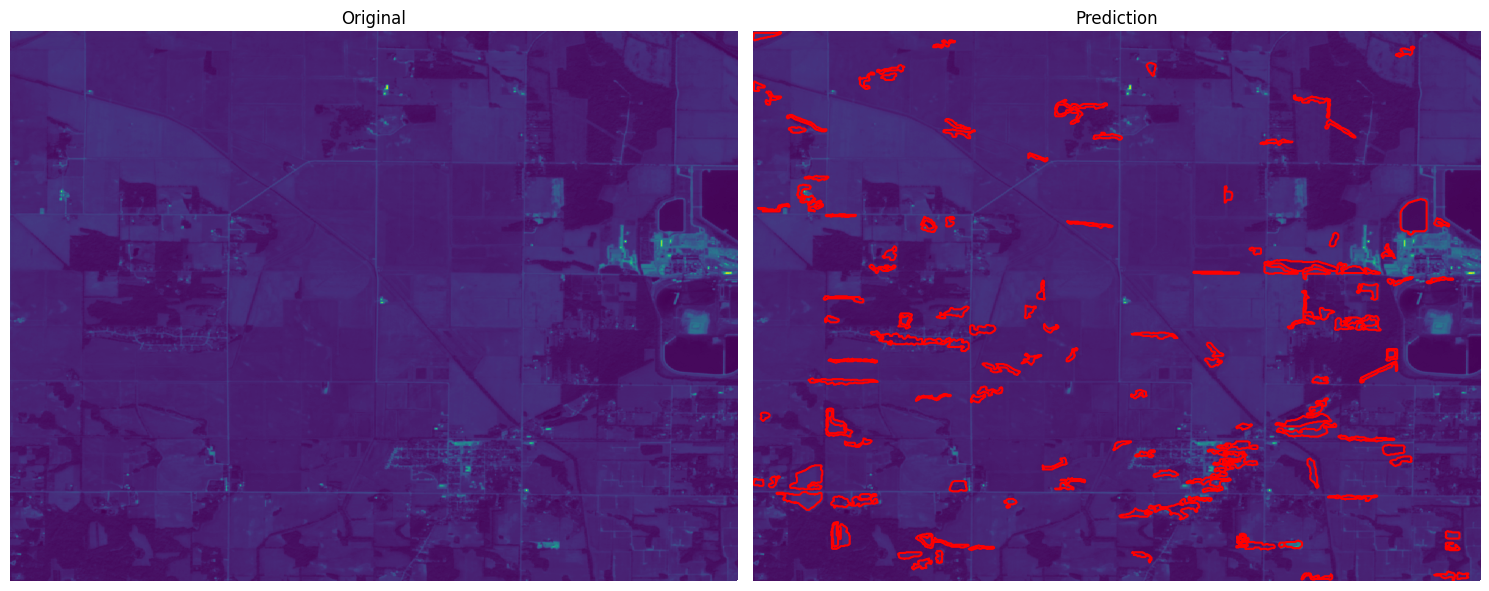

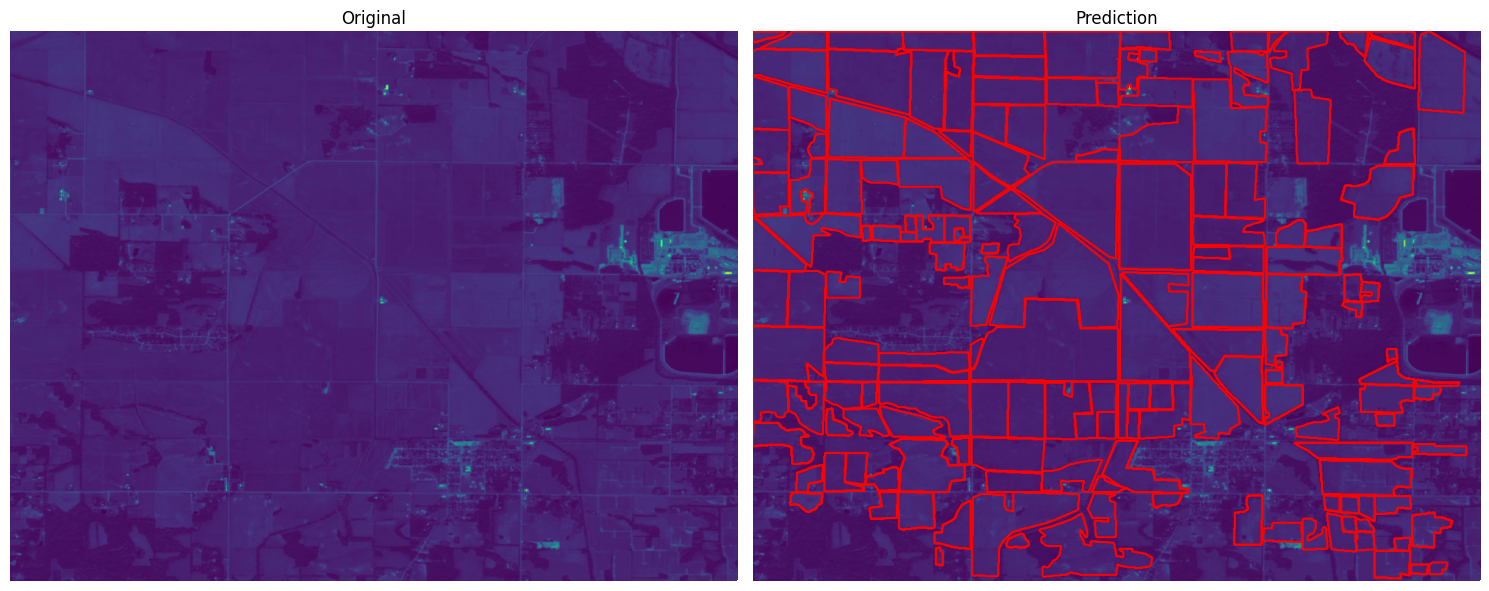

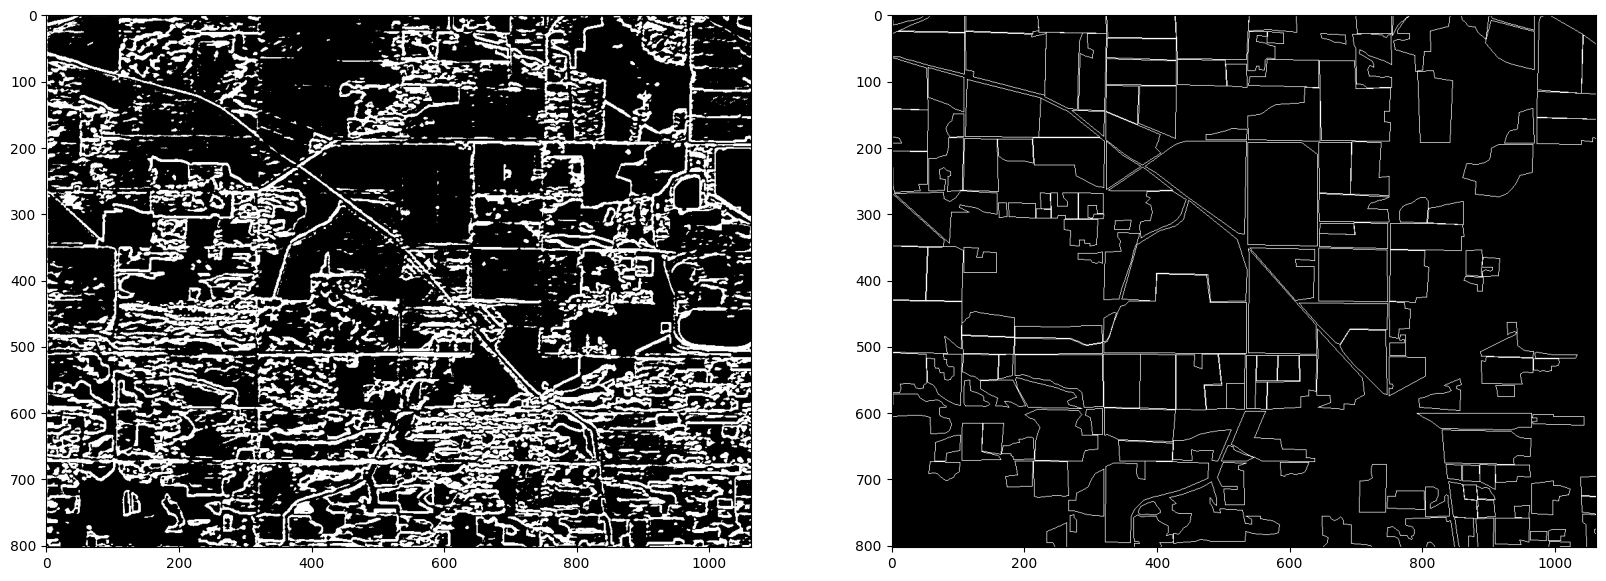

In [ ]:
model.eval()
SIGMOID = torch.nn.Sigmoid()
for i, f in enumerate(TRAIN_IMG_FILE_NAMES):
  if i == 1:
    img, padding, o_height, o_width  = CONSTANT_HELPER.preprocess_img(TRAIN_PATH, f)
    pred = model(torch.unsqueeze(img[channels].to(device), dim=0))

    mask = SIGMOID(pred).detach().cpu().numpy()[0][0][:o_height, :o_width]
    pg, cmask = mask_to_polygons(mask, 0.5, padding)
    compare_image_and_bounds(rasterio.open(os.path.join(TRAIN_PATH, f)), polygons=pg)

    true_mask = CONSTANT_HELPER.img_to_mask[f][:o_height, :o_width]
    true_pg = mask_to_polygons_org(true_mask)
    compare_image_and_bounds(rasterio.open(os.path.join(TRAIN_PATH, f)), polygons=true_pg)

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
    ax[0].imshow(cmask, cmap = 'gray')
    ax[1].imshow(true_mask, cmap = 'gray')
    break

# Conclusion

The UNET is able to predict the rough boundaries of fields in satellite images, however, there are a lot of noise and minor mispredictions. This makes it difficult for extracting polygons from the predicted mask. In conclusion, this was less effective than using the Mask R-CNN approach.

Next, we'll try predicting lines and junctions rather than predicting each pixel.